### Importando las librerias

In [72]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

### Importando los datasets

In [73]:
df_train_values = pd.read_csv('../datasets/train_values.csv')
df_train_labels = pd.read_csv('../datasets/train_labels.csv')

### Daños por orientación

#### hago el filtro de los datos

La hipótesis planteada es que position indica la orientación según sea Norte, Sur, Este u Oeste. Creemos que puede influir el daño según la orientación por las zonas montañosas. 

In [74]:
df_train_values_filtered = df_train_values.loc[:, ['building_id', 'position', 'geo_level_1_id']]
df_train_values_filtered

,building_id,position,geo_level_1_id
0,802906,t,6
1,28830,s,8
2,94947,t,21
3,590882,s,22
4,201944,s,11
...,...,...,...
260596,688636,s,25
260597,669485,s,17
260598,602512,s,17
260599,151409,j,26


#### Calculo la cantidad de edificios por orientación

In [75]:
total_buildings_by_position = df_train_values_filtered\
    .groupby(['position'])\
    .count()\
    .reset_index()\
    .rename(columns={ 'building_id': 'total_buildings_by_position' })[['position', 'total_buildings_by_position']]
total_buildings_by_position

,position,total_buildings_by_position
0,j,13282
1,o,2333
2,s,202090
3,t,42896


Podemos observar que una gran mayoría de las casas tienen un tipo de orientación, sin saber de donde son, se podría suponer que pertenecen a las zonas montañosas o algún tipo de zona que impida tener casas en otras direcciones.

In [76]:
df_train_values_filtered.loc[df_train_values_filtered['position']=='s',:]\
    .groupby(['position', 'geo_level_1_id'])\
    .count()\
    .reset_index()\
    .rename(columns={ 'building_id': 'total_buildings_in_s_by_geo' })

,position,geo_level_1_id,total_buildings_in_s_by_geo
0,s,0,3529
1,s,1,2340
2,s,2,744
3,s,3,3180
4,s,4,13275
5,s,5,2488
6,s,6,18089
7,s,7,14738
8,s,8,13322
9,s,9,3201


Con este análisis podemos descartar que haya mas edificios con cierta orientación por donde están ubicadas, dado que la distribución es bastante pareja.

#### Hago el merge de los datos

In [77]:
df_position_and_damage = df_train_labels.merge(df_train_values_filtered).merge(total_buildings_by_position)
df_position_and_damage

,building_id,damage_grade,position,geo_level_1_id,total_buildings_by_position
0,802906,3,t,6,42896
1,94947,3,t,21,42896
2,7962,3,t,17,42896
3,452227,2,t,17,42896
4,633759,2,t,6,42896
...,...,...,...,...,...
260596,736425,2,o,3,2333
260597,569298,2,o,7,2333
260598,275969,2,o,27,2333
260599,618590,2,o,3,2333


#### Hago el calculo del porcentaje de los distintos daños en una misma orientación

In [78]:
df_position_and_damage_with_percentage = df_position_and_damage\
    .groupby(['position', 'damage_grade', 'total_buildings_by_position'])\
    .count()\
    .rename(columns = { 'building_id': 'total_buildings_by_position_and_damage' })\
    .reset_index()
df_position_and_damage_with_percentage['porcentaje'] = (df_position_and_damage_with_percentage['total_buildings_by_position_and_damage'] * 100) / df_position_and_damage_with_percentage['total_buildings_by_position']

In [79]:
df_position_and_damage_with_percentage_bar =  df_position_and_damage_with_percentage.pivot(index='position', columns='damage_grade',values='porcentaje')
df_position_and_damage_with_percentage_bar

damage_grade,1,2,3
position,,,
j,12.61,59.47,27.92
o,5.14,68.97,25.89
s,9.83,57.43,32.74
t,8.07,52.92,39.01


Text(0, 0.5, 'Porcentaje')

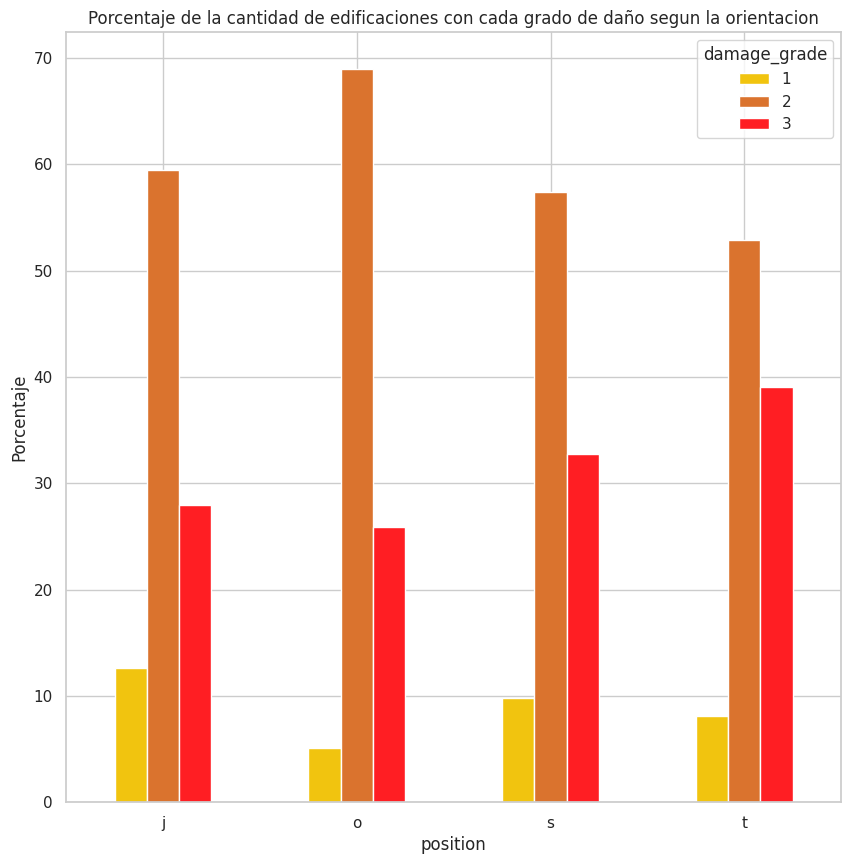

In [80]:
df_position_and_damage_with_percentage_bar.plot(kind='bar',figsize=(10,10), rot=0, \
 title='Porcentaje de la cantidad de edificaciones con cada grado de daño segun la orientacion',
 color={ 1: '#f1c40f', 2: '#da732e', 3: '#ff1e23' })
ax=plt.gca()
ax.set_xlabel('position')
ax.set_ylabel('Porcentaje')

El único dato posible que podemos observar, pese a no ser relevante, es que la orientación de tipo __t__ es el mas dañado, pero como comentabamos, no significa nada estando solo.